# Fourier-Basis Perturbations

This notebook discusses capabilities of the toolbox that were used to carry out the experiments reported in [Fourier-Based Augmentations for Improved Robustness and Uncertainty Calibration](https://arxiv.org/abs/2202.12412), which was presented as a poster at a NeurIPS 2021 workshop in distribution shifts. 


In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

from functools import partial

import numpy as np
import torch as tr

from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchmetrics import Accuracy


from rai_toolbox.augmentations import FourierPerturbation
from rai_toolbox.augmentations.fourier import create_heatmaps
from rai_toolbox.metrics import CalibrationError

from utils import load_model_from_yaml, renorm, imshow, plot_heatmaps

norm = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

data = CIFAR10(
    "~/.torch/data/cifar/",
    transform=ToTensor(),
    train=False,
)

classes = (
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

base_model = load_model_from_yaml(model_name="base_model")
robust_model = load_model_from_yaml(model_name="jsd_fourier")


def predict_img(img: tr.Tensor, model: tr.nn.Module) -> str:
    return classes[model(norm(img[None])).argmax(-1).item()]


predict_base = partial(predict_img, model=base_model)

## Introducing Fourier-Basis Perturbations

We will introduce Fourier-basis perturbations, where a 2D plane wave of a specified magnitude, frequency, orientation, and phase-shift is added pixel-wise to an image. These simple perturbations can cause a surprising amount of deterioration in a model's performance. Indeed, a single, high-frequency perturbation can even be used as a so-called universal adversarial perturbation.

In [2]:
img, label = data[10]

fourier_transform = FourierPerturbation(
    (32, 32), norm_scale=(1.0, 1.0), freq_bounds=[10, 20], num_distinct_phases=10
)

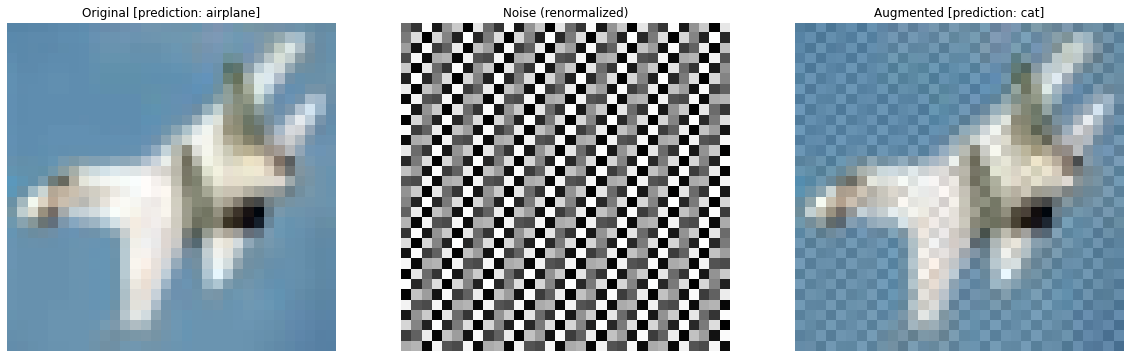

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 10))
f_img = fourier_transform(img)
noise = f_img - img

imshow(ax1, img, title=f"Original [prediction: {predict_base(img)}]")
imshow(ax2, noise, title="Noise (renormalized)")
imshow(ax3, f_img, title=f"Augmented [prediction: {predict_base(f_img)}]")


## Creating Susceptibility Heatmaps

To assess how vulnerable a given model is to Fourier-basis perturbations, we will render a "susceptibilty heatmap". Depicted below is a heatmap that shows the classification error of a WideResNet architecture, which was trained on CIFAR10. Each pixel in the heatmap reports the classification error against the CIFAR10 test set – that has been perturbed by a *single* plane wave of a given frequency and orientation. "Hotter" means higher error-rate.

The pixels are arranged such that:
- The center pixel corresponds to a plane wave of 0-frequency. I.e. this is the "clean" test accuracy of the model.
- Moving radially-outward from the center corresponds to plane waves of increasing frequency.
- The polar angle of a pixel from the x-axis (about the center) determines the orientation of the plane wave.

The magnitude and phase-shift of the plane waves are held constant across the all perturbations. So this particular heatmap tells us that the model is most susceptible to high-frequency, diagonally-oriented plane wave perturbations. 

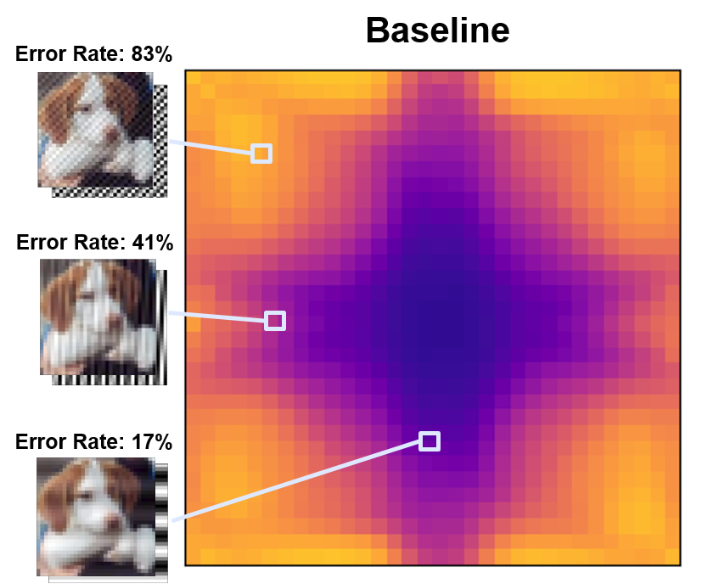

Let's generate heatmaps for a subset of CIFAR10 training images. We'll measure both classification error and RMS calibration error. The plane wave perturbations will be normalized such that the L2 norm of each plane wave will be 2.0.

In [2]:
# random subset of 100 test images
sampled_indices = np.random.choice(np.arange(len(data)), replace=False, size=100)
subset = Subset(data, sampled_indices)

loader = DataLoader(subset, shuffle=False, batch_size=100, num_workers=0, pin_memory=True)

In [3]:
results = create_heatmaps(
    loader,
    (32, 32),
    model=base_model,
    basis_norm=2.0,
    rand_flip_per_channel=False,
    post_pert_batch_transform=norm,
    device="cuda:0",
    metrics=dict(accuracy=Accuracy, calibration_error=partial(CalibrationError, 15)),
)

awoooga


batch:   0%|          | 0/1 [00:00<?, ?it/s]

fourier-grid:   0%|          | 0/512 [00:00<?, ?it/s]

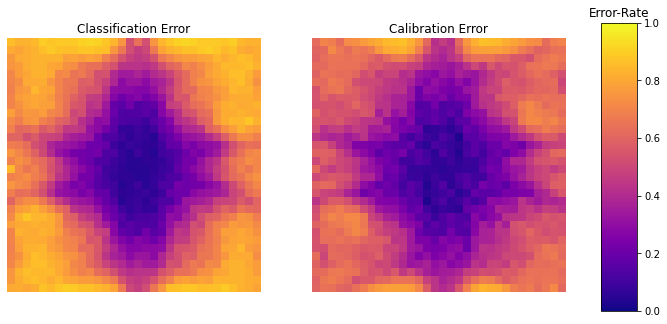

In [4]:
fig, ax = plot_heatmaps(results)

We see that the model is highly susceptible to such perturbations. There are many plane wave perturbations that can reduce a model to near-guessing performance.

How can we bolster our model's robustness to this sort of noise, while also inculcating robustness to other forms of common image corruptions?

## Improving Robustness with AugMix

[AugMix](https://arxiv.org/abs/1912.02781) is a surprisingly effective image augmentation methodology, which composes a collection of image augmentation "primitives" and mixes the original image with a linear combination of augmented versions of the image.

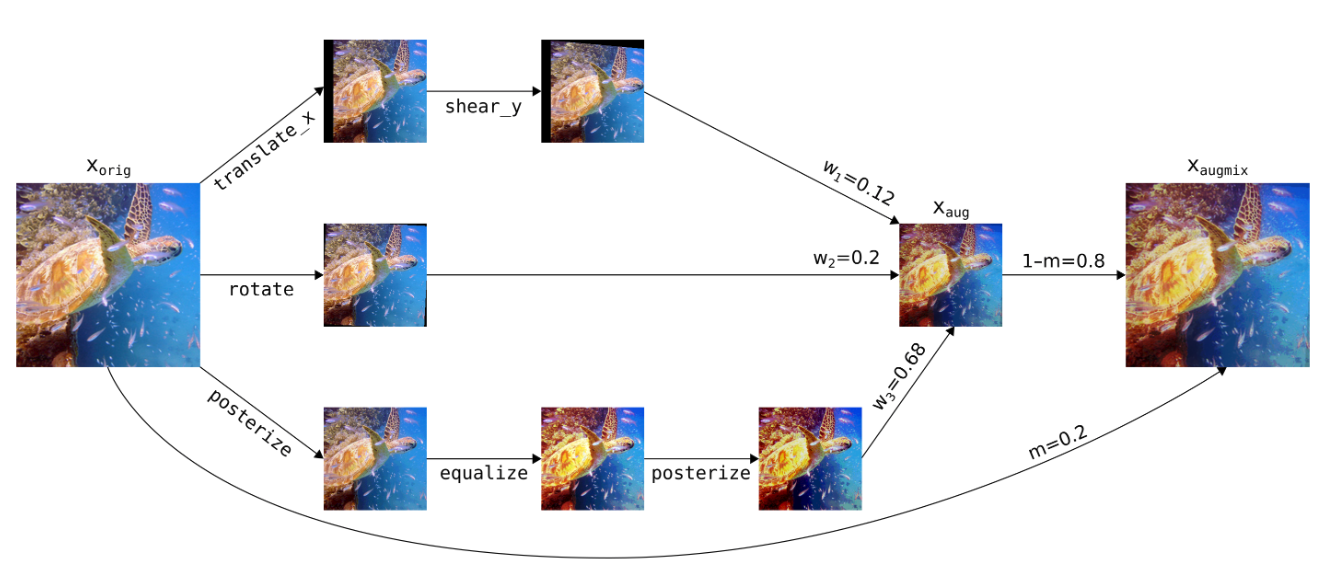

In addition to using augmentation primitives – such as shear, translate, rotate, posterize, and gaussian noise – we can also include our Fourier-basis perturbations in the AugMix process.

In [7]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
    ToTensor,
    ColorJitter,
    GaussianBlur,
    RandomSolarize,
    RandomAffine,
    RandomRotation,
)


from rai_toolbox.augmentations import AugMix, Fork

# increase magnitude to make its effect obvious to human eye -- for purpose of demo
fourier_transform2 = FourierPerturbation(
    (32, 32), norm_scale=(2.0, 2.0), freq_bounds=[4, 5], num_distinct_phases=10
)

primitives = [
    GaussianBlur(7, sigma=(1.0, 2.0)),
    RandomSolarize(0.5),
    ColorJitter(brightness=(0.75, 0.75)),
    RandomAffine(20),
    fourier_transform2,
]

pre_process = norm


augmix = AugMix(
    process_fn=pre_process,
    augmentations=primitives,
    aug_chain_depth=4,
    augmentation_choice_probs=[1, 1, 1, 1, 4],
)

train_transform = Compose(
    transforms=[
        ToTensor(),
        RandomHorizontalFlip(),
        RandomCrop(32, padding=4),
        Fork(pre_process, augmix),
    ]
)


aug_data = CIFAR10(
    "~/.torch/data/cifar/",
    transform=train_transform,
    train=True,
)

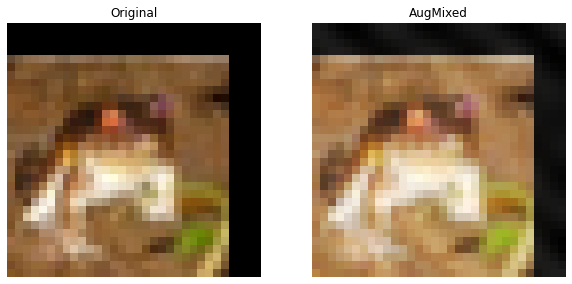

In [8]:
imgs = aug_data[0][0]

fig, axes = plt.subplots(ncols=len(imgs), figsize=(10, 10))


imshow(axes[0], imgs[0], title=f"Original")
for ax, img in zip(axes[1:], imgs[1:]):

    imshow(ax, img, title="AugMixed")


## Robustness of a Model Trained with AugMix[Fourier, ...]

Let's see how using AugMix – with our Fourier perturbation added to the primitives – affects our model's heatmaps.

In [9]:
robust_results = create_heatmaps(
    loader,
    (32, 32),
    model=robust_model,
    basis_norm=2.0,
    rand_flip_per_channel=False,
    post_pert_batch_transform=norm,
    device="cuda:0",
    metrics=dict(accuracy=Accuracy, calibration_error=partial(CalibrationError, 15)),
)

batch:   0%|          | 0/1 [00:00<?, ?it/s]

fourier-grid:   0%|          | 0/512 [00:00<?, ?it/s]

Let's recall what the old heatmaps looked like:

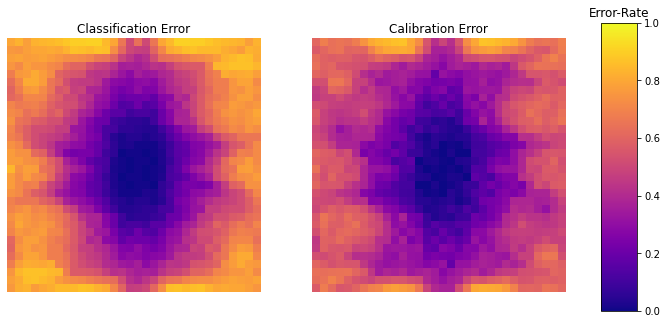

In [10]:

fig, ax = plot_heatmaps(results)

Here is the heatmap for the robust model

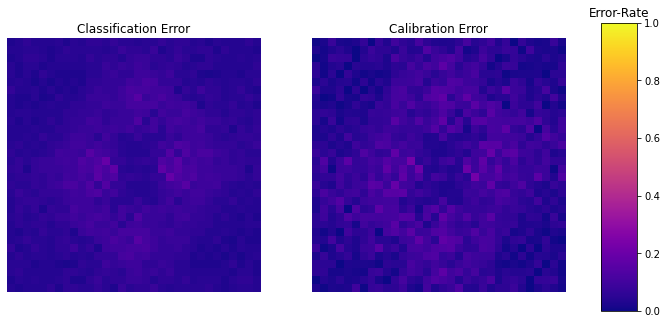

In [11]:
fig, ax = plot_heatmaps(robust_results)

Our model is not only robust to Fourier-basis perturbations, but it is also significantly more robust to other common corruptions – *this is true even compared to a model trained with AugMix (but without Fourier perturbations)*. 

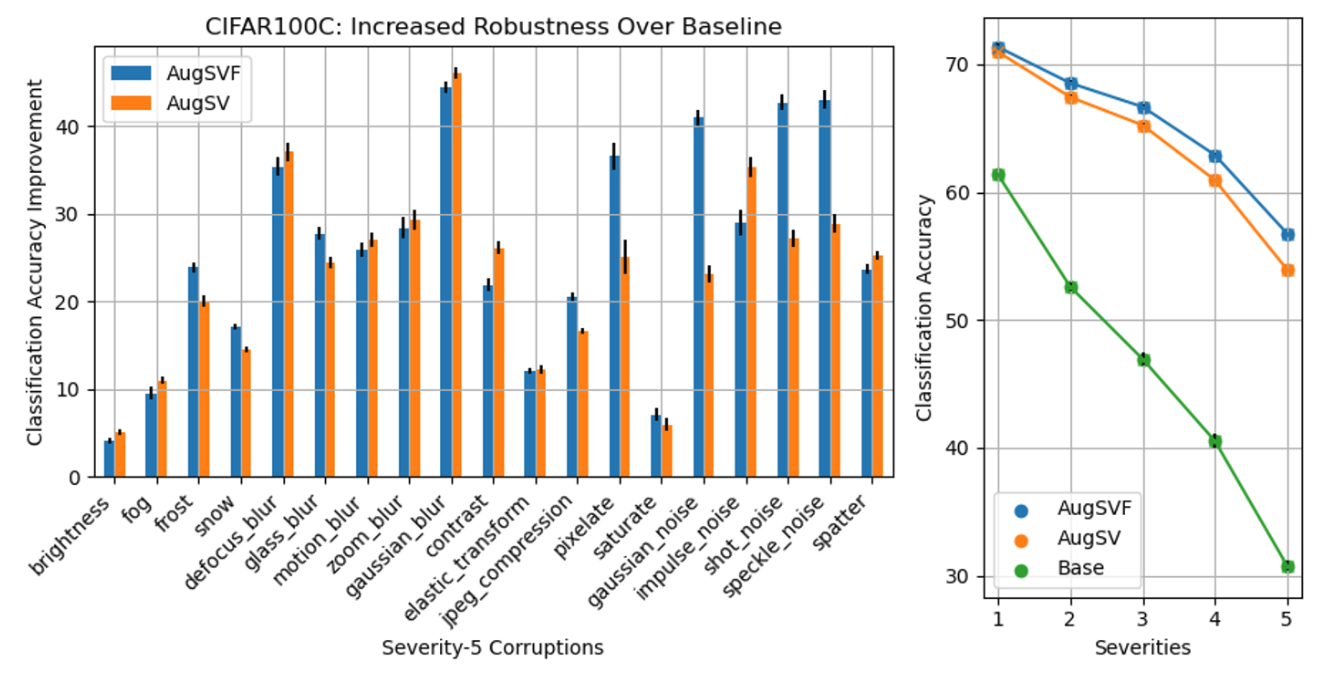

## Reusable components from the toolbox
- `rai_toolbox.augmentations.FourierPerturbation`
- `rai_toolbox.augmentations.fourier.create_heatmaps`
- `rai_toolbox.metrics.CalibrationError`
- `rai_toolbox.augmentations.AugMix`
- `rai_toolbox.augmentations.Fork` (used to create multiple augmented images -- used for consistency-loss with AugMix)
- `rai_toolbox.losses.jensen_shannon_divergence` (used as a consistency loss with AugMix)